In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

%matplotlib inline 

# Take Two
After exploring Greg's data, I thought it would be better to have someone with a larger dataset of plants with the desired positional accuracy. "evanaturalist" also had near 100,000 observations but with many more plants. So I did a second round of prelim exploration on her data set, thinking I could possible pick plants here as target species and run my modeling off those. 

I made the mistake here that I did with Greg, confusing "positional_accuracy" for "public_positional_accuracy", but it isn't worth correcting because I have since decided on a different method for "slicing" iNaturalist data toward the exploration of my central questions. 

So again, __I do NOT expect much worth will come from reviewing below__. Anything I found of worth in this exploration is applied in the Spicata set. I have not bothered to do more thorough annotations here than what "doodling" I did to begin with. The notebook fizzles out--exactly where I decided on the alternate method for "slicing" iNaturalist data. But I leave it here for documentation.

In [2]:
data_eva = pd.read_csv("../../data/observations-evanaturalist.csv")

C:\Users\lisa_\AppData\Local\Temp\ipykernel_57804\2299292130.py:1: DtypeWarning: Columns (11,24,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  data_eva = pd.read_csv("../../data/observations-evanaturalist.csv")


In [3]:
data_eva.head()

,id,time_observed_at,time_zone,created_at,updated_at,quality_grade,license,url,image_url,sound_url,...,scientific_name,common_name,iconic_taxon_name,taxon_id,taxon_kingdom_name,taxon_class_name,taxon_order_name,taxon_family_name,taxon_genus_name,taxon_species_name
0,14999692,NaN,Eastern Time (US & Canada),2018-07-31 23:09:40 UTC,2018-11-22 10:29:33 UTC,research,CC-BY-NC,https://www.inaturalist.org/observations/14999692,https://inaturalist-open-data.s3.amazonaws.com...,NaN,...,Ambystoma texanum,Small-mouthed Salamander,Amphibia,26745.0,Animalia,Amphibia,Caudata,Ambystomatidae,Ambystoma,Ambystoma texanum
1,15000453,NaN,Eastern Time (US & Canada),2018-07-31 23:39:47 UTC,2023-04-23 23:36:37 UTC,needs_id,CC-BY-NC,https://www.inaturalist.org/observations/15000453,https://inaturalist-open-data.s3.amazonaws.com...,NaN,...,Spilosoma virginica,Virginian Tiger Moth,Insecta,60839.0,Animalia,Insecta,Lepidoptera,Erebidae,Spilosoma,Spilosoma virginica
2,15005158,NaN,Eastern Time (US & Canada),2018-08-01 02:27:54 UTC,2018-08-03 23:12:43 UTC,needs_id,CC-BY-NC,https://www.inaturalist.org/observations/15005158,https://inaturalist-open-data.s3.amazonaws.com...,NaN,...,Alisma,water-plantains,Plantae,60254.0,Plantae,Liliopsida,Alismatales,Alismataceae,Alisma,NaN
3,15029656,NaN,Eastern Time (US & Canada),2018-08-01 22:37:42 UTC,2023-10-22 08:00:22 UTC,needs_id,CC-BY-NC,https://www.inaturalist.org/observations/15029656,https://inaturalist-open-data.s3.amazonaws.com...,NaN,...,Sagittaria sagittifolia,Sagittifolia group,Plantae,1504193.0,Plantae,Liliopsida,Alismatales,Alismataceae,Sagittaria,NaN
4,15029889,NaN,Eastern Time (US & Canada),2018-08-01 22:46:35 UTC,2018-08-01 22:46:39 UTC,needs_id,CC-BY-NC,https://www.inaturalist.org/observations/15029889,https://inaturalist-open-data.s3.amazonaws.com...,NaN,...,Pleurotus ostreatus,Oyster Mushroom,Fungi,48494.0,Fungi,Agaricomycetes,Agaricales,Pleurotaceae,Pleurotus,Pleurotus ostreatus


# Quick Clean
Dropping the few rows with most essential information missing (time observed and/or latitude/longitude) before running an initial analysis to determine if this is a robust enough dataset.

In [4]:
# dropping missing observed time rows and confirming
data_eva.dropna(subset=['time_observed_at'], inplace=True)
print(f'Number of null time_observed_at entries = {data_eva[data_eva["time_observed_at"].isnull()].shape[0]}')

Number of null time_observed_at entries = 0


In [5]:
# dropping missing latitude time rows and confirming
data_eva.dropna(subset=['latitude'], inplace=True)
print(f'Number of null time_observed_at entries = {data_eva[data_eva["latitude"].isnull()].shape[0]}')

Number of null time_observed_at entries = 0


In [6]:
# changing to datetimes
data_eva["time_observed_at"] = pd.to_datetime(data_eva["time_observed_at"])
data_eva["created_at"] = pd.to_datetime(data_eva["created_at"])
data_eva["updated_at"] = pd.to_datetime(data_eva["updated_at"])

In [7]:
data_eva.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89050 entries, 50 to 90751
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype              
---  ------                            --------------  -----              
 0   id                                89050 non-null  int64              
 1   time_observed_at                  89050 non-null  datetime64[ns, UTC]
 2   time_zone                         89050 non-null  object             
 3   created_at                        89050 non-null  datetime64[ns, UTC]
 4   updated_at                        89050 non-null  datetime64[ns, UTC]
 5   quality_grade                     89050 non-null  object             
 6   license                           89049 non-null  object             
 7   url                               89050 non-null  object             
 8   image_url                         89050 non-null  object             
 9   sound_url                         0 non-null      float64   

In [8]:
data_eva.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89050 entries, 50 to 90751
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype              
---  ------                            --------------  -----              
 0   id                                89050 non-null  int64              
 1   time_observed_at                  89050 non-null  datetime64[ns, UTC]
 2   time_zone                         89050 non-null  object             
 3   created_at                        89050 non-null  datetime64[ns, UTC]
 4   updated_at                        89050 non-null  datetime64[ns, UTC]
 5   quality_grade                     89050 non-null  object             
 6   license                           89049 non-null  object             
 7   url                               89050 non-null  object             
 8   image_url                         89050 non-null  object             
 9   sound_url                         0 non-null      float64   

## Initial Analysis 
The best positional accuracy for research [according to iNaturalist](https://www.inaturalist.org/posts/2035-observation-location-accuracy) is less than or equal to 30 m.

I am looking for a dataset that has a high number of Plantae records with positional accuracy of 30 m or less, so am doing this initial analysis prior to formal cleaning and EDA to ensure the dataset has the qualities that would then warrant the labor of cleaning and further analysis.

In order to approximate the experience of finding an endangered plant, I plan to create test sets out of Plantae observations that are rare for this user to encounter, so will be looking at the set of observations whose scientific name occurs rarely within this larger set. 

### Positional Accuracy

In [9]:
pos_acc_desired = 30  #specify number of meters desired for positional accuracy

In [10]:
# Describing positional accuracy range and center values
round(data_eva["positional_accuracy"].describe(),2)

count      88356.00
mean        1019.95
std        11465.75
min            1.00
25%            2.00
50%            8.00
75%           83.00
max      1247072.00
Name: positional_accuracy, dtype: float64

In [11]:
# How many entries with positional accuracy <= 30 m?
o = data_eva[data_eva['positional_accuracy'] <= pos_acc_desired].shape[0]
print(f'There are {o} observations with positional accuracy of {pos_acc_desired}m or less.')

There are 58159 observations with positional accuracy of 30m or less.


The non null set of positional_accuracy with values less than 200m has 80307 values


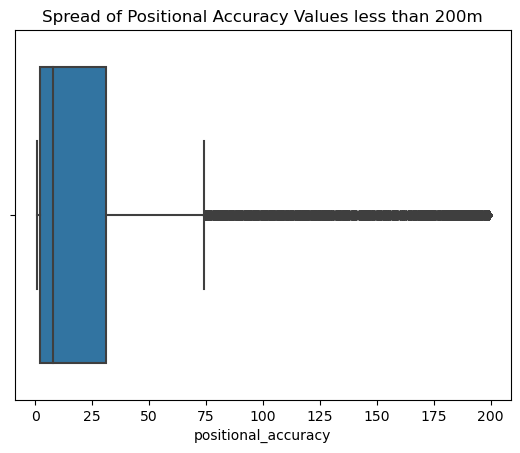

In [12]:
# boxplot of positional accuracy non null values with upper Limit
PA_notnull = pd.DataFrame(data_eva[data_eva["positional_accuracy"].notnull()]["positional_accuracy"])
Limit = 200 #change this number to see other spreads
sns.boxplot(x = "positional_accuracy", 
            data = PA_notnull[PA_notnull["positional_accuracy"] < Limit]) \
            .set_title(f'Spread of Positional Accuracy Values less than {Limit}m')
print(f'The non null set of positional_accuracy with values less than {Limit}m',
      f'has {PA_notnull[PA_notnull["positional_accuracy"] < Limit].shape[0]} values')

### Adding Plantae Filter

In [13]:
# number of Plantae observations with positional accuracy 30 m or less
o = data_eva[(data_eva["taxon_kingdom_name"] == 'Plantae') & \
         (data_eva["positional_accuracy"] <= pos_acc_desired)]\
.shape[0]
print(f'There are {o} Plantae observations with positional accuracy of {pos_acc_desired}m or less.')

There are 33906 Plantae observations with positional accuracy of 30m or less.


# WHICH CATEGORY?
Below between taxon_species_name or species_guess?

In [14]:
# series of all plant species with desired positional accuracy
# by species name and count of observations
plant_species = data_eva[(data_eva["taxon_kingdom_name"] == 'Plantae') & \
          (data_eva["positional_accuracy"] <= pos_acc_desired)]['taxon_species_name'] \
 .value_counts().sort_values()


# count of Plant species with necessary positional accuracy
# that also occurs rarely 
Max_occurences = 2 #specify max number of desired occurences 
o = plant_species[plant_species.values <= Max_occurences].sum()

total_o = plant_species.sum()

print(f'Of all the Plantae observations with positional accuracy of {pos_acc_desired}m or less, \n' \
      f'{o} out of {total_o} of them were observed and identified at the species level \n' \
     f'as rarely as {Max_occurences} or fewer times.')

Of all the Plantae observations with positional accuracy of 30m or less, 
922 out of 24880 of them were observed and identified at the species level 
as rarely as 2 or fewer times.


In [15]:
# series of all plant species with desired positional accuracy
# by species name and count of observations
plant_species = data_eva[(data_eva["taxon_kingdom_name"] == 'Plantae') & \
          (data_eva["positional_accuracy"] <= pos_acc_desired)]['species_guess'] \
 .value_counts().sort_values()


# count of Plant species with necessary positional accuracy
# that also occurs rarely 
Max_occurences = 2 #specify max number of desired occurences 
o = plant_species[plant_species.values <= Max_occurences].sum()

total_o = plant_species.sum()

print(f'Of all the Plantae observations with positional accuracy of {pos_acc_desired}m or less, \n' \
      f'{o} out of {total_o} of them were observed and identified at the species level \n' \
     f'as rarely as {Max_occurences} or fewer times.')

Of all the Plantae observations with positional accuracy of 30m or less, 
2095 out of 33906 of them were observed and identified at the species level 
as rarely as 2 or fewer times.


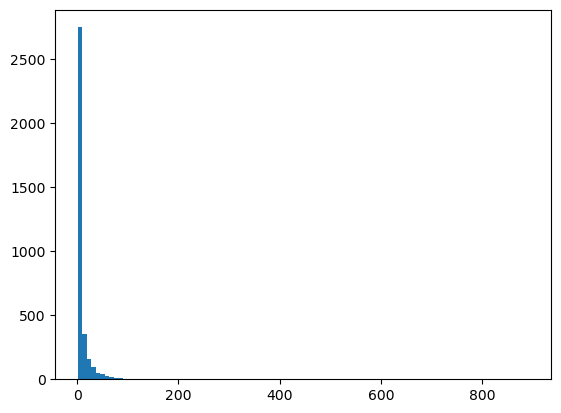

In [16]:


plt.figure()
plt.hist(plant_species, bins = 100)
plt.show()

In [17]:
data_eva[data_eva["common_name"]=="Fungi Including Lichens"]["taxon_kingdom_name"].isna().sum()

0

In [18]:
data_eva[data_eva["common_name"]=="Virginia Springbeauty"]["taxon_species_name"].value_counts()

Claytonia virginica    530
Name: taxon_species_name, dtype: int64

In [19]:
data_eva["taxon_geoprivacy"].value_counts()

open        14658
obscured      938
Name: taxon_geoprivacy, dtype: int64